<a href="https://colab.research.google.com/github/priyanshsingh1765/Quantum-Machine-Learning-CPP-2024/blob/main/Assignment3/cpp_qml_assignment_3_22b1856.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad
from torch import tan, sin, cos

# Eqn 30:
- $\frac{df}{dx} + \lambda f \left( \kappa + \tan(\lambda x) \right) = 0, \quad f(0) = 1,
$


- $\kappa$ and $\lambda$ control the exponential and sinusoidal properties of f respectively

# The analytical solution with the above boundary condition
- y(x) = $\exp(-\kappa \lambda x) \cos(\lambda x)$

In [44]:
#function to compute the analytical solution value
def analytical_solution(KAPPA, LAMBDA, points):
    return ((np.e)**(-KAPPA*LAMBDA*points))*np.cos(LAMBDA*points)

# function that solves the equation, with all the circuit and optimizer settings as inputs
def solve_diff_eqn(N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS, LAMBDA, KAPPA, fm_type, tower, n_iter, reg_penalty = 0, reg_points = tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])):

    manual_seed(404)

    ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH) #hardware efficient ansatz

    if(tower == True): #Whether to apply a tower scheme in the feature map circuit
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type,  reupload_scaling = ReuploadScaling.TOWER)
    else:
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type)

    obs = total_magnetization(n_qubits=N_QUBITS) #The cost function operator

    circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz)) #"Chaining the feature map and the variational circuits"
    model = QNN(circuit=circuit, observable=obs, inputs=["x"]) #setting up the model

    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam optimizer

    def reg_loss(reg_points_list, current_iter, total_iter): #Regularization loss
        diff = analytical_solution(KAPPA, LAMBDA, reg_points_list) - model(tensor(reg_points_list))
        return (1 - (current_iter/total_iter))*(diff.pow(2).mean())

    def loss_fn(inputs, outputs, current_iter, total_iter, regul_penalty): #loss function with the DE loss, boundary condition, regularization
        dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
        ode_loss = dfdx + LAMBDA*outputs*(KAPPA + tan(LAMBDA*inputs))
        boundary_loss = model(zeros_like(inputs)) - ones_like(inputs)
        return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean() + regul_penalty*reg_loss(reg_points, current_iter, total_iter)

    min_loss = np.inf #min loss needed as the optimizer doesnt reduce the loss monotonically
    best_model = model #model with the least loss

    for epoch in range(n_iter):
        opt.zero_grad()
        cp = tensor(uniform(low=-0.99, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
        loss = loss_fn(inputs=cp, outputs=model(cp), current_iter = epoch + 1, total_iter = n_iter, regul_penalty = reg_penalty)

        if(loss.detach().numpy() < min_loss): #update the minimum loss and the best model
           min_loss = loss.detach().numpy()
           best_model = model

        loss.backward()
        opt.step()
        print(f"epoch {epoch} done, loss = {loss}")

    model = best_model #update the best model
    cp = tensor(uniform(low=-0.99, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
    final_loss = loss_fn(cp, model(cp), 0, 1, 1).detach().numpy()

    sample_points = linspace(-1, 1, steps=100).reshape(-1, 1)
    analytic_sol = (((np.e)**(-KAPPA*LAMBDA*sample_points))*np.cos(LAMBDA*sample_points))

    dqc_sol = model(sample_points).detach().numpy()
    x_data = sample_points.detach().numpy()

    return x_data, analytic_sol, dqc_sol, min_loss, final_loss

# Solving the DE with $\kappa = 0.1, \lambda = 1$
- Using a chebysehv feature map
- 6 qubit feature map
- Depth 20 hardware efficient ansatz

In [ ]:
x_data, analytic_sol, dqc_sol, min_loss, final_loss = solve_diff_eqn(N_QUBITS=6, DEPTH=20, LEARNING_RATE=0.01, N_POINTS=20, LAMBDA=1, KAPPA=0.1, fm_type="Chebyshev", tower = False, n_iter=200)

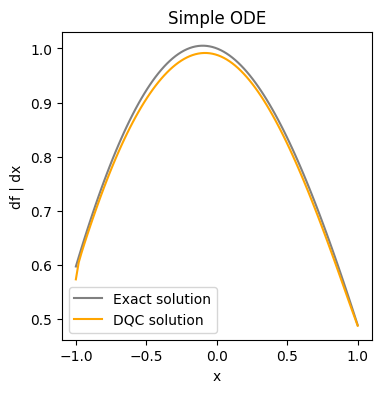

In [38]:
# plot
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df | dx")
plt.title("Simple ODE")
plt.legend()
plt.show()


# The effect of $\kappa$ on the ability of the feature map to represent the solution
- $\kappa$ values tested for: [0.1, 0.5, 1, 2]
- $\lambda$ = 1
- 6 qubit feature map
- Depth 20 hardware efficient ansatz

In [ ]:
x_data_list = []
analytic_sol_list = []
dqc_sol_list = []
final_loss_list = []
min_loss_list = []

for kappa_iter in [0.1, 0.5, 1, 2]:
    x_data, analytic_sol, dqc_sol, min_loss, final_loss = solve_diff_eqn(N_QUBITS=6, DEPTH=20, LEARNING_RATE=0.01, N_POINTS=20, LAMBDA=1, KAPPA=kappa_iter, fm_type="Chebyshev", tower = False, n_iter=300)
    x_data_list.append(x_data)
    analytic_sol_list.append(analytic_sol)
    dqc_sol_list.append(dqc_sol)
    final_loss_list.append(final_loss)
    min_loss_list.append(min_loss)

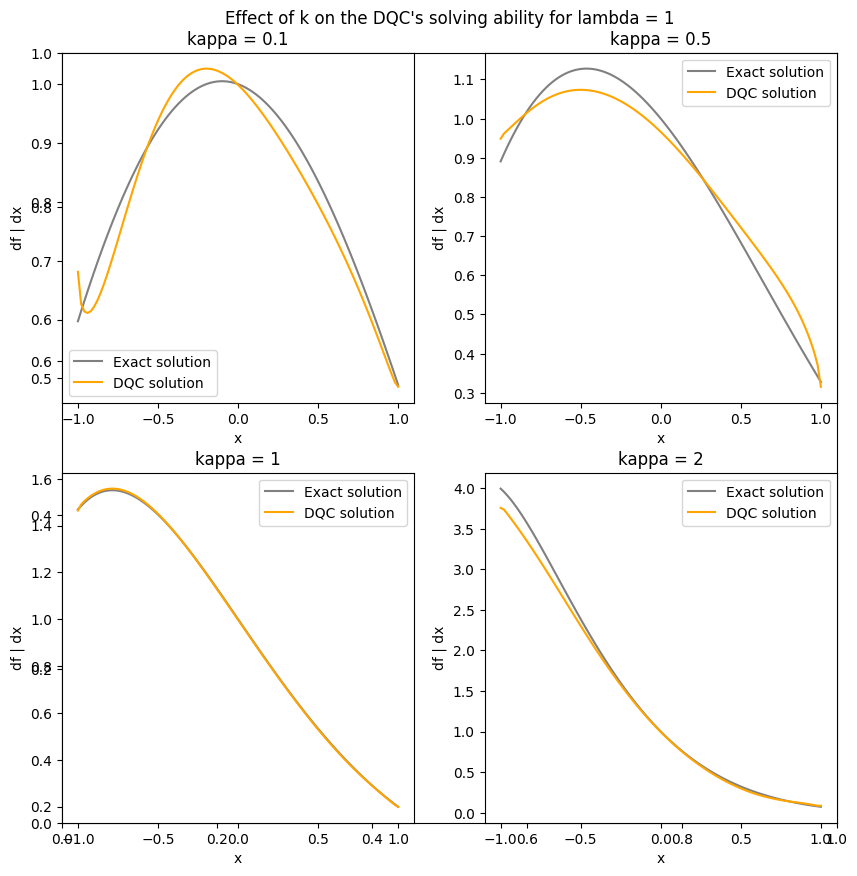

In [50]:
plt.figure(figsize = (10, 10))
plt.title("Effect of k on the DQC's solving ability for lambda = 1\n")
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(x_data_list[i], analytic_sol_list[i].flatten(), color="gray", label="Exact solution")
    plt.plot(x_data_list[i], dqc_sol_list[i].flatten(), color="orange", label="DQC solution")
    plt.xlabel("x")
    plt.ylabel("df | dx")
    plt.title(f"kappa = {[0.1, 0.5, 1, 2][i]}")
    plt.legend()
    plt.show

# Eqn 32: An equation with highly non trivial dynamics:
- $\frac{df}{dx} - 4f + 6f^2 - \sin(50x) - f\cos(25x) + \frac{1}{2} = 0, \quad f(0) = 0.75$
- 100 training points
- Optimizer Adam
- 10 qubit feature map

## Solving it classically

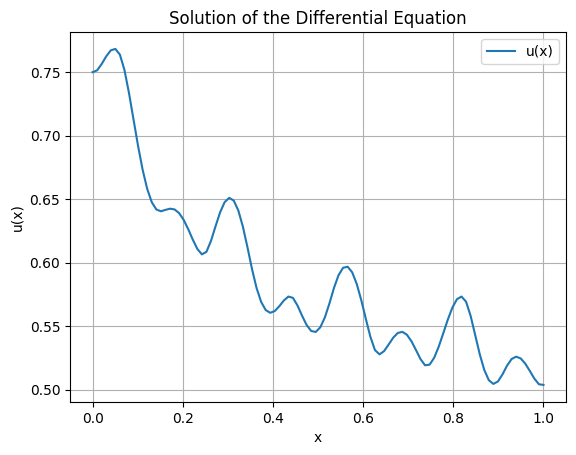

In [56]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def ode(x, u):
    return 4 * u - 6 * u**2 + np.sin(50 * x) + u * np.cos(25 * x) - 0.5

u0 = 0.75
x_span = (0, 1)  # Solve from x=0 to x=1
x_eval = np.linspace(0, 1, 100)  # Points to evaluate the solution

solution = solve_ivp(ode, x_span, [u0], t_eval=x_eval, method='RK45')

x = solution.t
u = solution.y[0]

plt.plot(x, u, label='u(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid()
plt.show()


## Solving using a DQC

In [93]:
#function to compute the analytical solution value
analytical_solution = interp1d(solution.t, solution.y[0], kind='cubic', fill_value="extrapolate")

# function that solves the equation, with all the circuit and optimizer settings as inputs
def solve_diff_eqn_32(N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS, fm_type, tower, n_iter, reg_points = [0, 0.2, 0.4, 0.6, 0.8, 1]):

    manual_seed(404)

    ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH) #hardware efficient ansatz

    if(tower == True): #Whether to apply a tower scheme in the feature map circuit
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type,  reupload_scaling = ReuploadScaling.TOWER)
    else:
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type)

    obs = total_magnetization(n_qubits=N_QUBITS) #The cost function operator

    circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz)) #"Chaining the feature map and the variational circuits"
    model = QNN(circuit=circuit, observable=obs, inputs=["x"]) #setting up the model

    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam optimizer

    def loss_fn(inputs, outputs): #loss function with the DE loss, boundary condition, regularization
        dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
        ode_loss = dfdx - 4*outputs + 6*(inputs)**2 - sin(50*inputs) - outputs*cos(25*inputs) + 0.5
        boundary_loss = model(zeros_like(inputs)) - 0.75*ones_like(inputs)
        reg_loss = tensor(model(tensor(reg_points)).detach().numpy() - analytical_solution(reg_points))
        return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean() + 5*reg_loss.pow(2).mean()

    min_loss = np.inf #min loss needed as the optimizer doesnt reduce the loss monotonically
    best_model = model #model with the least loss

    for epoch in range(n_iter):
        opt.zero_grad()
        cp = tensor(uniform(low=0, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
        loss = loss_fn(inputs=cp, outputs=model(cp))

        if(loss.detach().numpy() < min_loss): #update the minimum loss and the best model
           min_loss = loss.detach().numpy()
           best_model = model

        loss.backward()
        opt.step()
        print(f"epoch {epoch} done, loss = {loss}")

    model = best_model #update the best model
    cp = tensor(uniform(low=0, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
    final_loss = loss_fn(cp, model(cp)).detach().numpy()

    sample_points = linspace(0, 1, steps=100).reshape(-1, 1)
    analytic_sol = analytical_solution(sample_points)

    dqc_sol = model(sample_points).detach().numpy()
    x_data = sample_points.detach().numpy()

    return x_data, analytic_sol, dqc_sol, min_loss, final_loss

In [ ]:
x_data, analytic_sol, dqc_sol, min_loss, final_loss = solve_diff_eqn_32(N_QUBITS = 10, DEPTH = 25, LEARNING_RATE = 0.01, N_POINTS = 100, fm_type = "Chebyshev", tower = True, n_iter = 200)

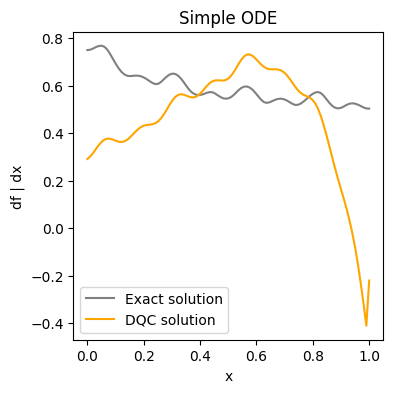

In [97]:
# plot
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df | dx")
plt.title("Simple ODE")
plt.legend()
plt.show()

# Observation from the above plot
- The deep, 10 qubit ansatz (with 25 layers) is not able to exactly mimic the actual solution.
- However, the complex oscillatory behaviour of the solution is being successfully captured, achieved by the high depth and tower enhanced feature map.

# References
- [Solving nonlinear differential equations with differentiable quantum circuits](https://arxiv.org/abs/2011.10395)
- [Qadence: a differentiable interface for digital-analog programs](https://arxiv.org/abs/2401.09915)